# OCloC Python Package - Bootstrapping

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
tutorial_path = pathlib.Path().resolve()
# Importing the main code.
module_path = os.path.abspath(os.path.join('..', 'src', 'ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ocloc import ProcessingParameters, ClockDrift
from ocloc import read_correlation_file

# Parameters for locating the files where the correlation files.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"

# The reference time is the date of deployment or zero time. 
reference_time = '2014-08-21T00:00:00.000000Z'

# Station info is a file with the stations' metadata
station_file = '/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info'

# Now we describe the processing parameters that will be used for all correlations.
params2 = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

# We load everything into our main object that will handle all the operations.
cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])

No correlation file found for station:O26


In [2]:
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq(method="weighted_lstsq")

cd.calculate_tapp_4_allcorrelations()
cd.calculate_dt_ins()
cd.remove_outiers(max_error=1.)
cd.calculate_dt_ins()
cd.build_matrices()
cd.solve_eq()

Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.


# Checking that the corrections we are applying are not introducing errors into our data.

For checking our intermidiate results is critical to check that the waveforms of different time-lapses align in a better way than before starting our operation.

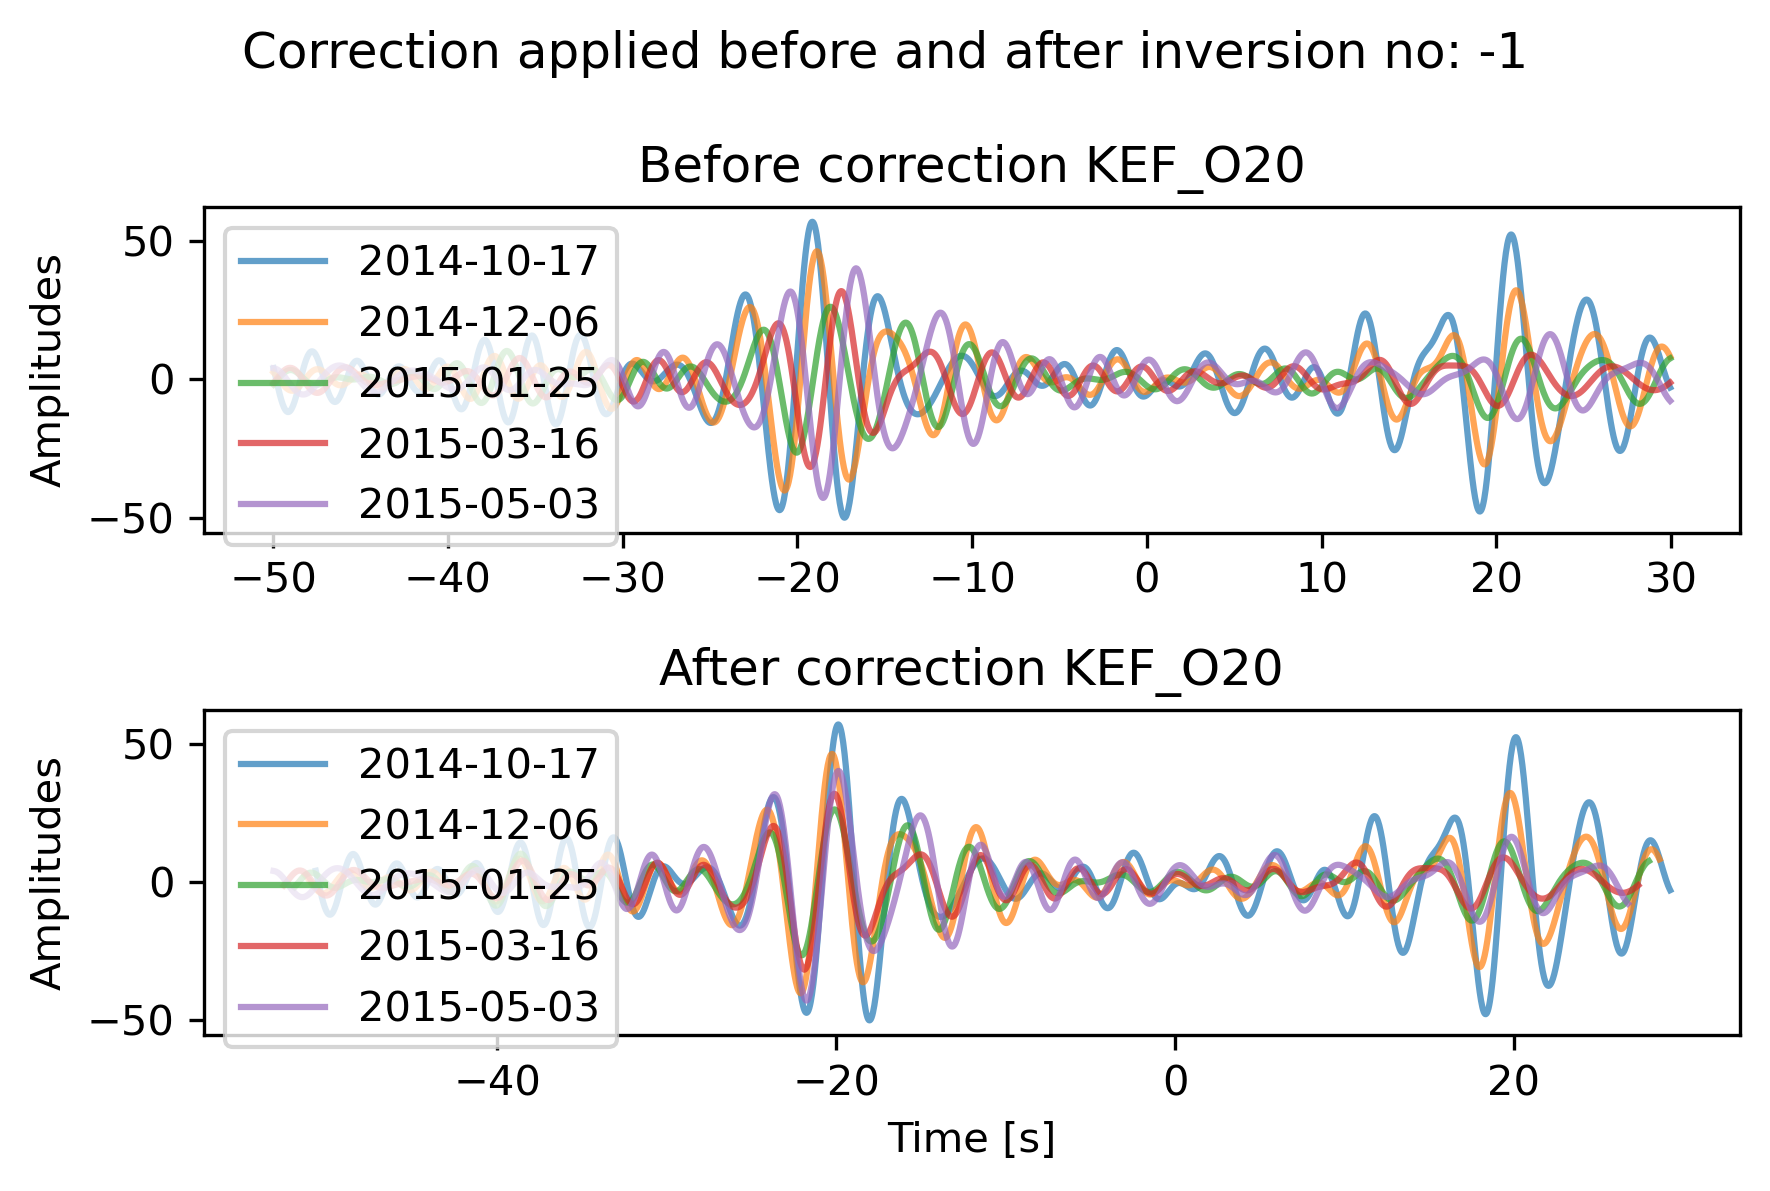

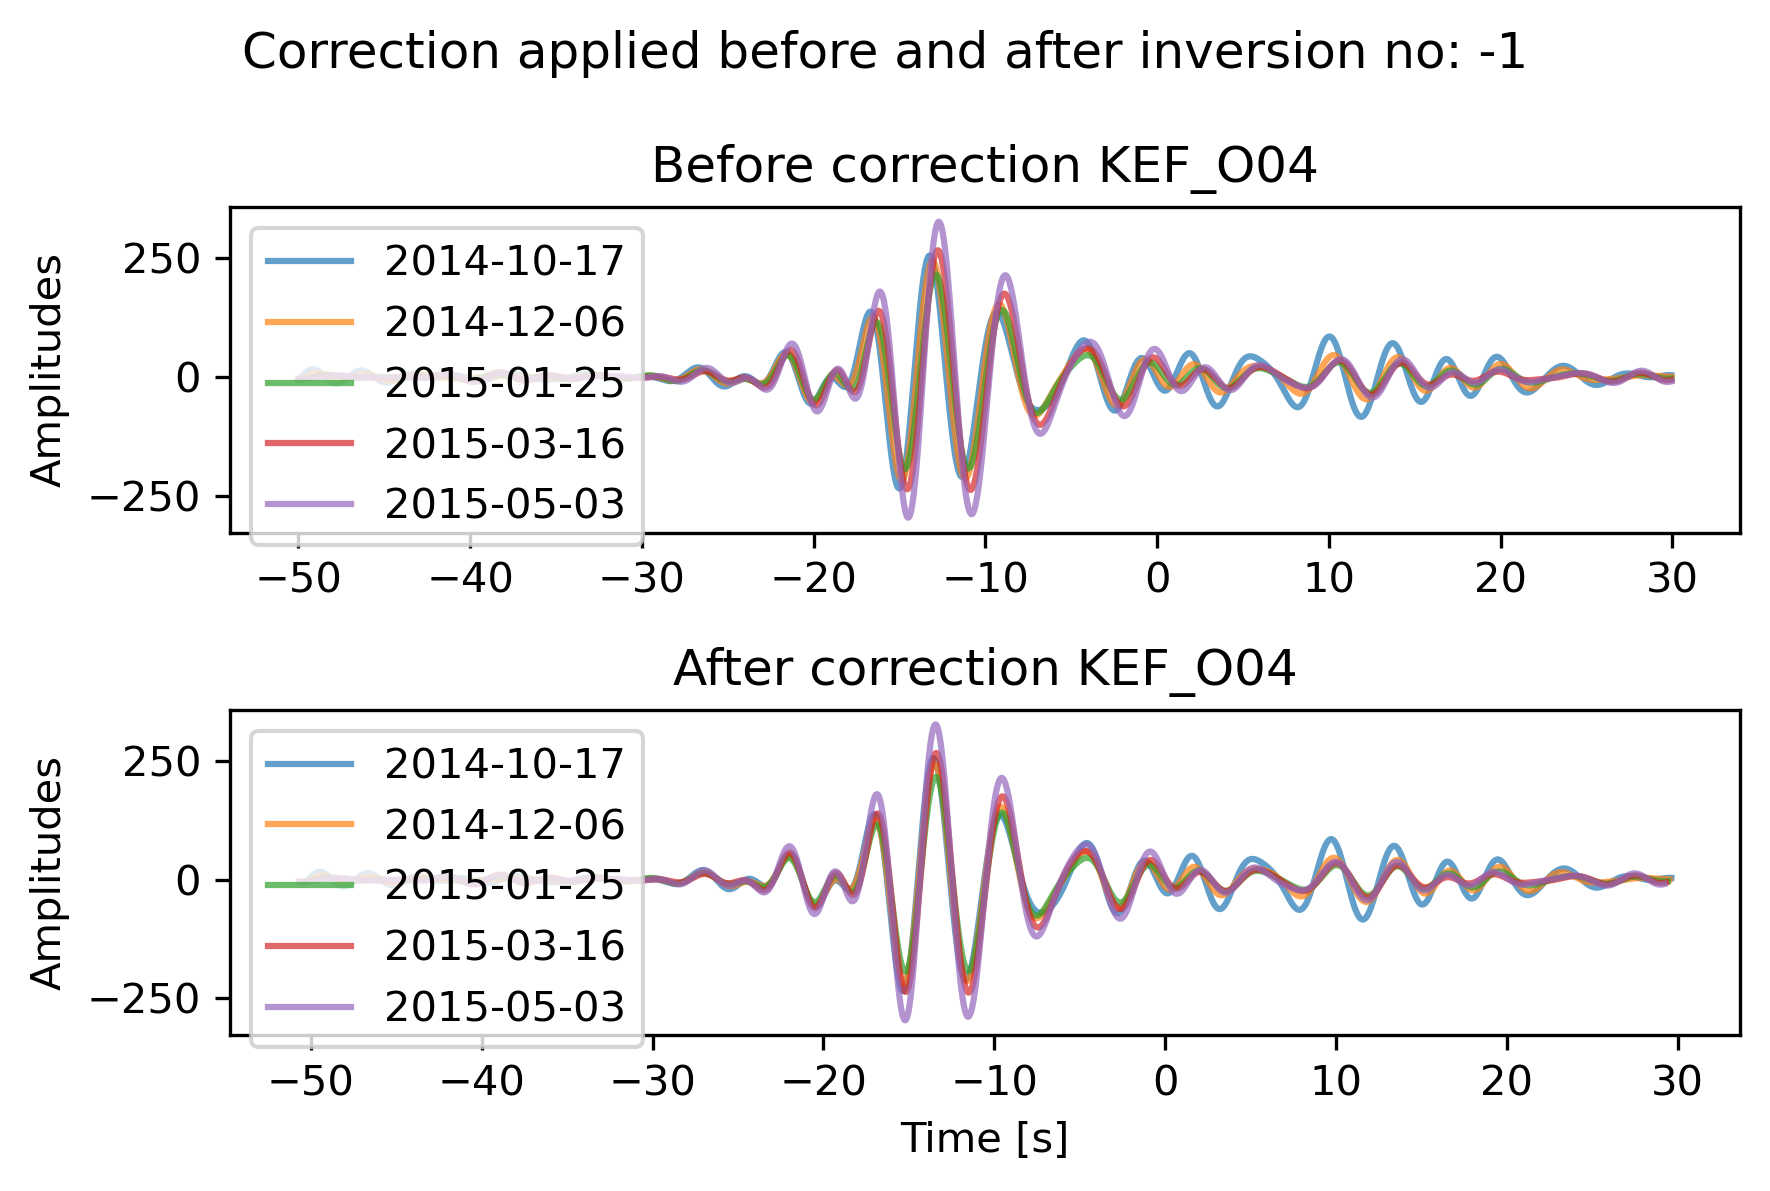

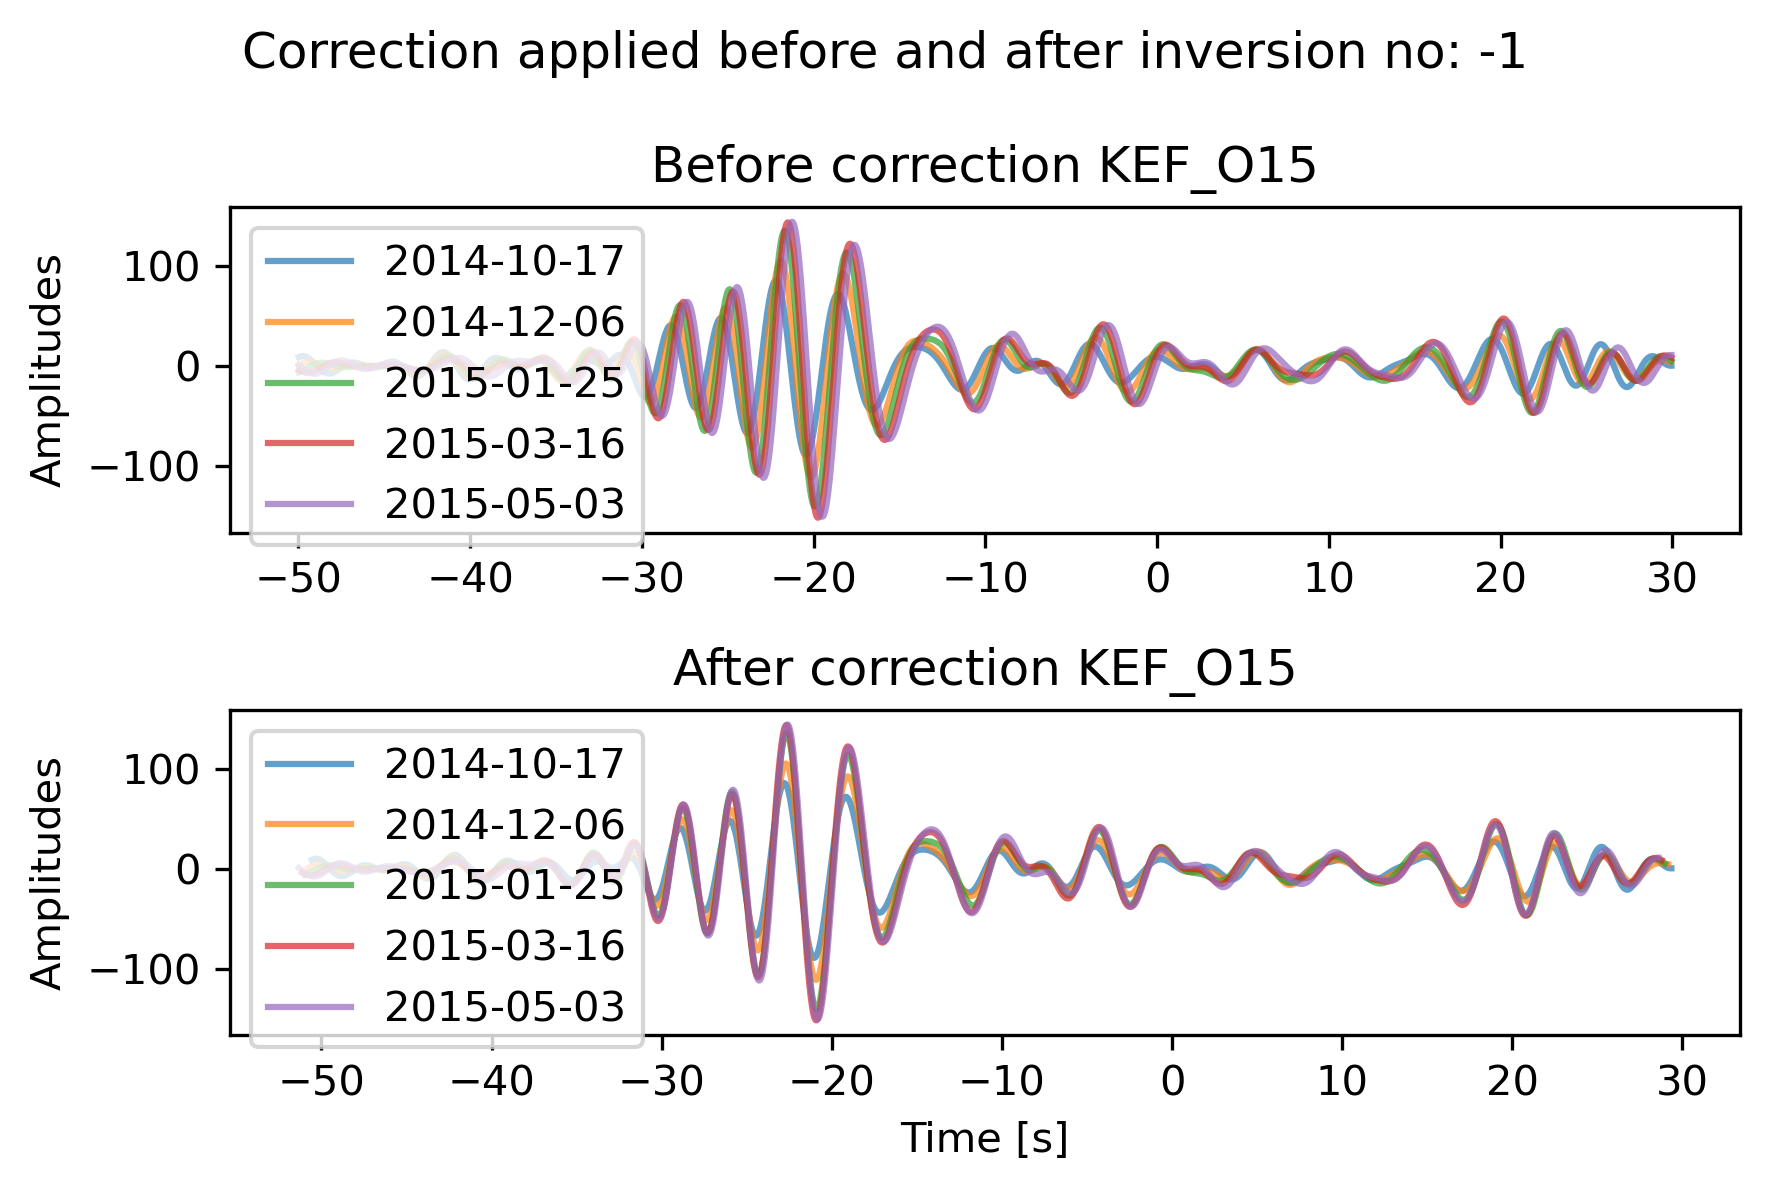

In [3]:
station2_code = "KEF"
for station_code in ["O20", "O04", "O15"]:
    cd.plot_correlation_beforeNafter_correction(station_code, station2_code)

# Convergence
We can run several inversions until the a and b values stop changing.
This can be checked by plotting the a's and b's of each station and looking for results that do not change anymore.


In [4]:
for i in range(3):
    cd.calculate_tapp_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.remove_outiers(max_error=1.)
    cd.calculate_dt_ins()
    cd.build_matrices()
    cd.solve_eq(method="weighted_lstsq")

Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


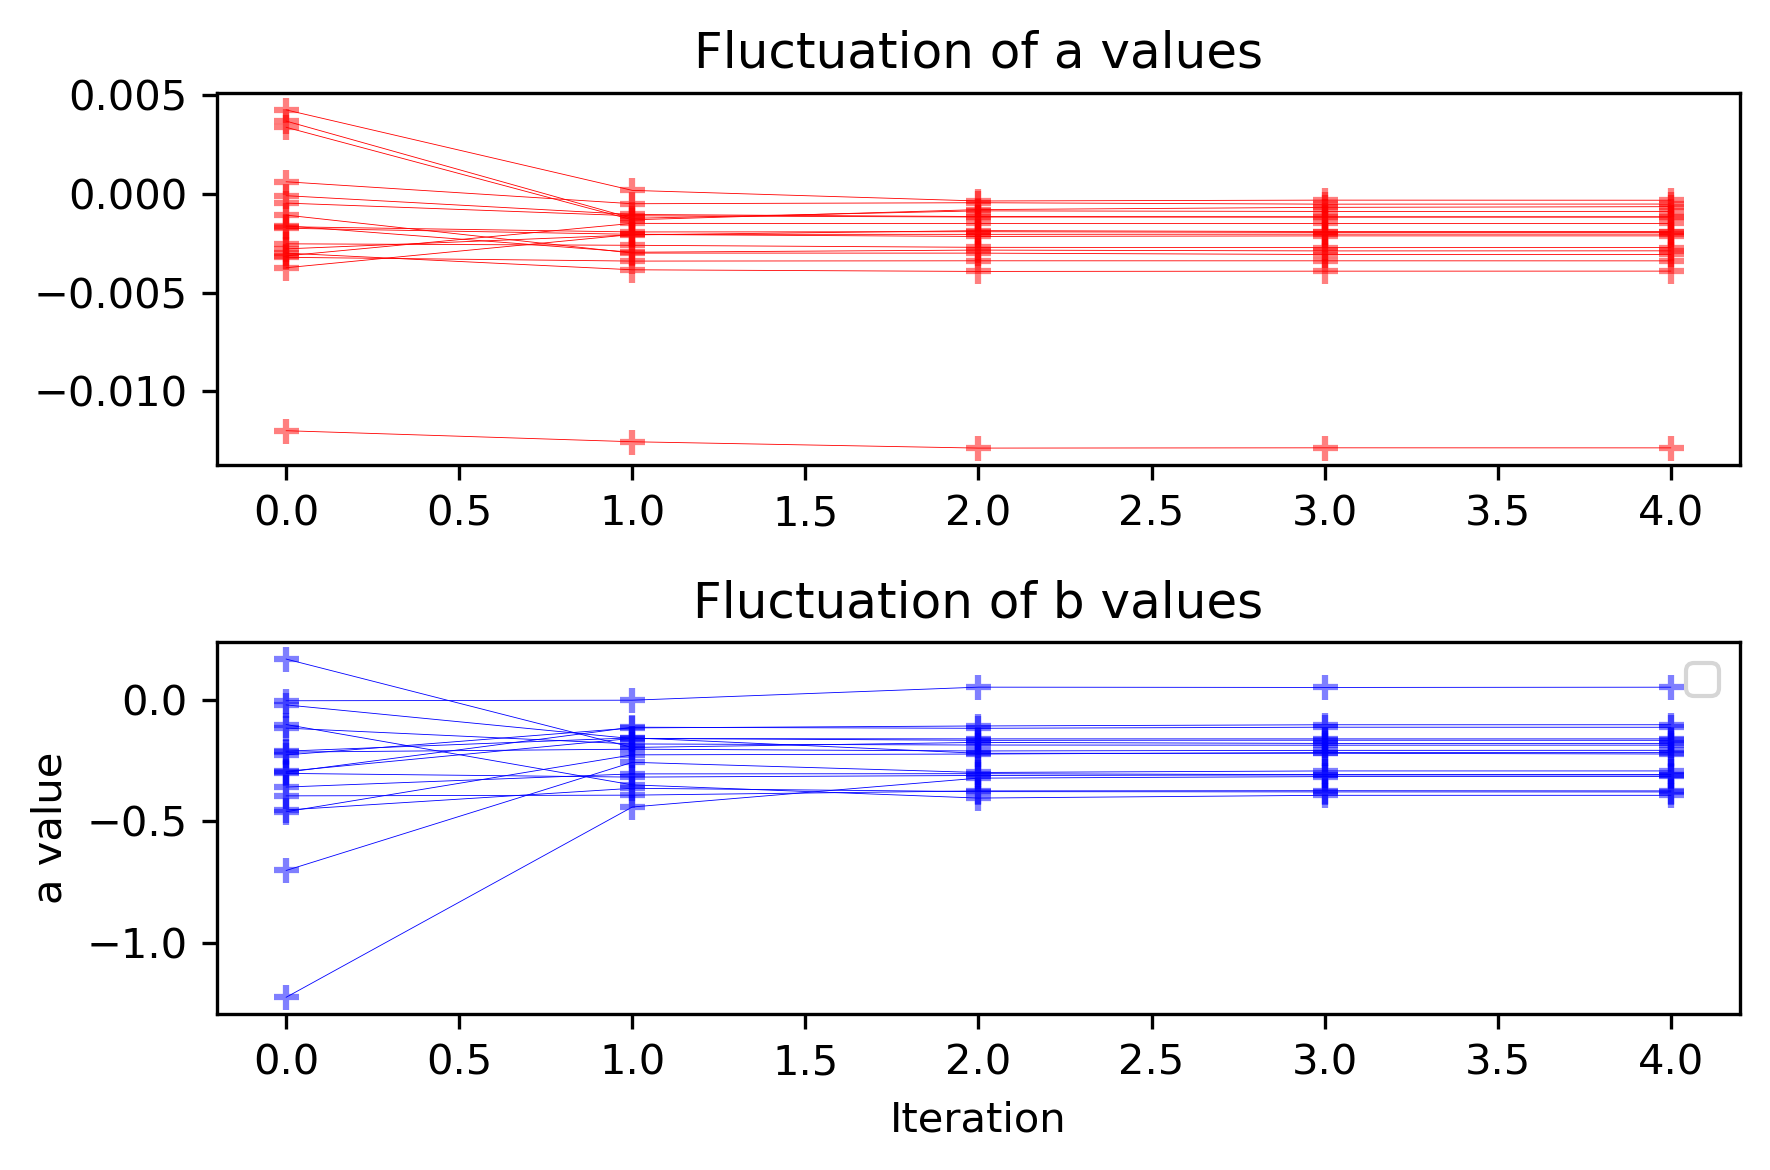

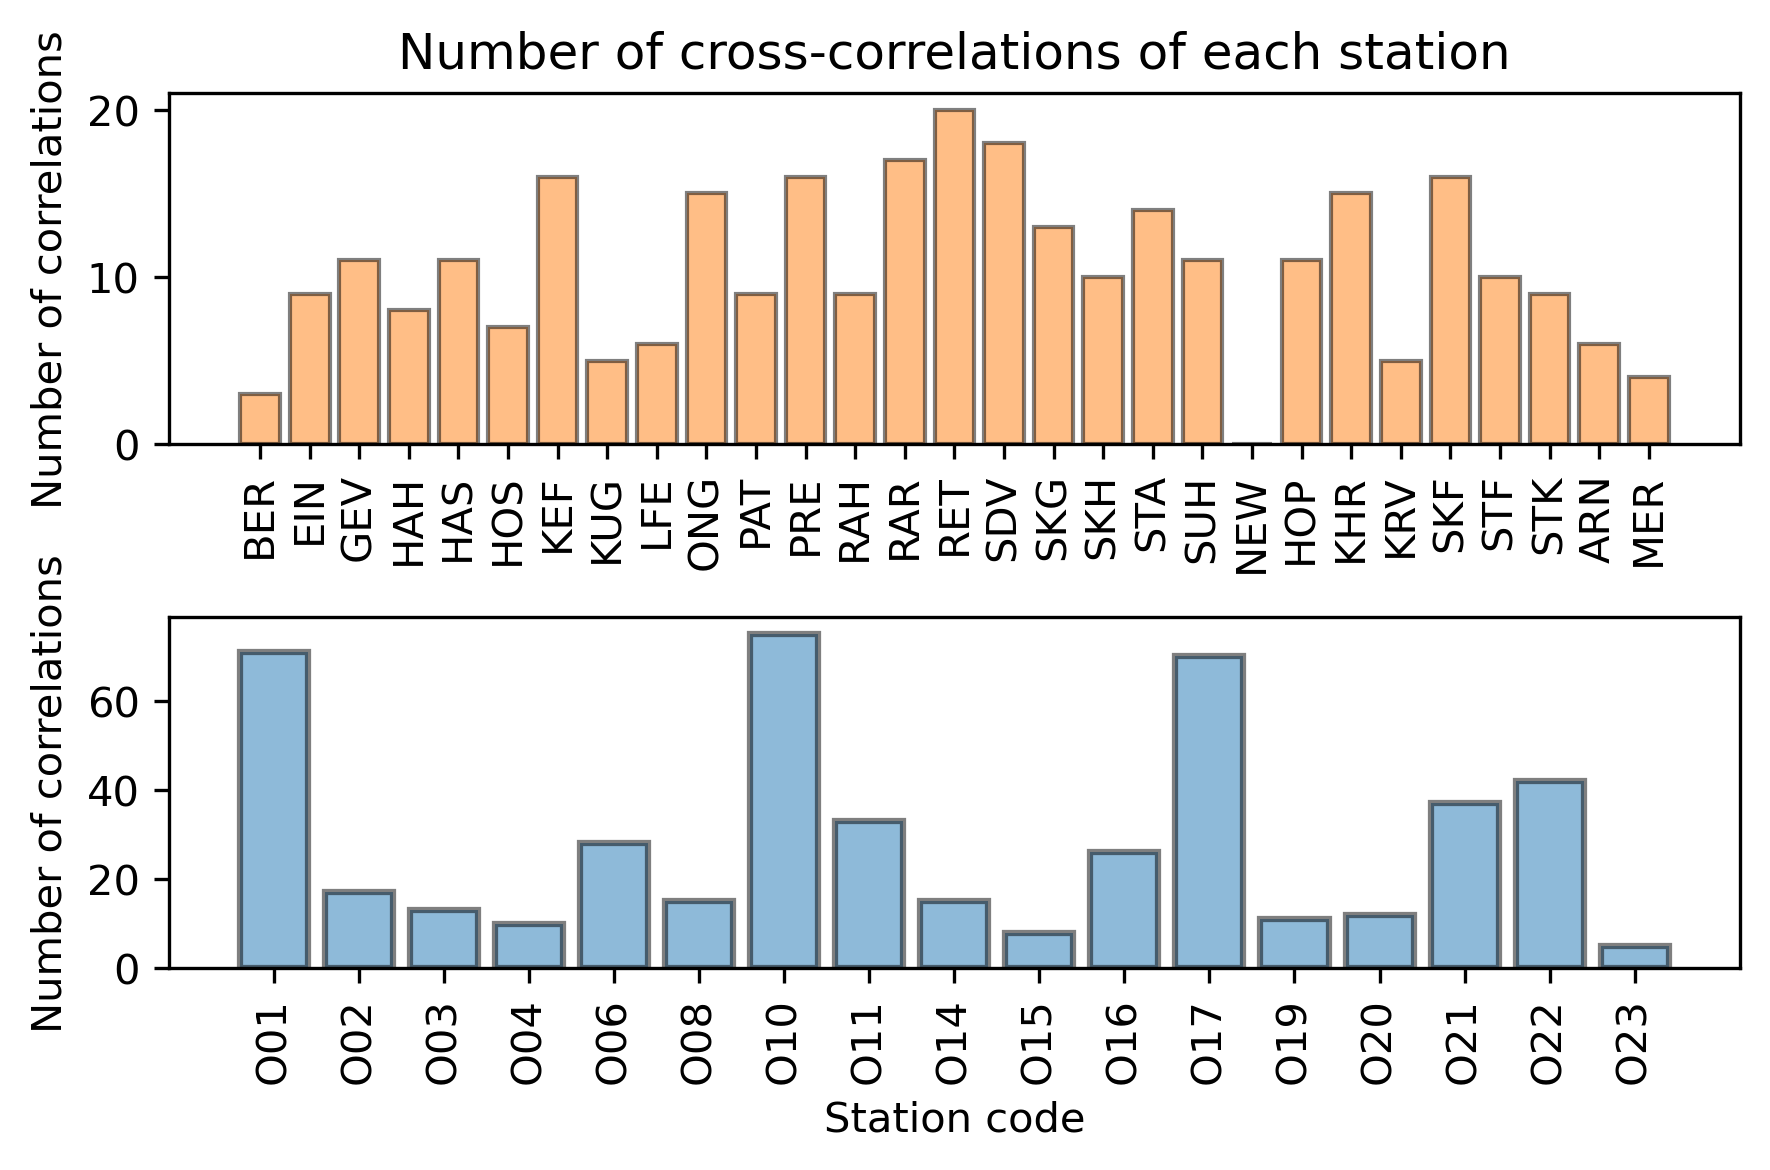

In [5]:
cd.plot_fluctuation_of_a_and_b()
cd.plot_hist_no_correlations_per_station()

# Inversion strategies tested with bootstrapping

We now compare the results from a weighted least squares inversion with the regular least squares inverison.

Bootstrapping is a kind of resampling. The idea is that we treat the sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement. DataFrame provides a method called sample we can use to select a random sample of the rows (Downey, 2020).

From the x measurements we select a subset of x measurements and we invert.
We store the mean a value and mean b value.
Then we repeat.

In [6]:
min_number_of_total_correlations = 2
min_number_correlation_periods = 2
min_number_of_stationconnections = 2

# Number of days can be the oldest average_date - earliest average_date
# divided by 10. The 86400 is to convert from seconds to days.
average_dates = [c.average_date for c in cd.correlations]
days_apart = (max(average_dates) - min(average_dates)) / (5 * 86400)

In [7]:
self = cd.copy()

NameError: name 'correlations_with_parameters' is not defined

In [ ]:
bootstrapped_cd = self.copy()

correlations_with_tapp = []
for c in bootstrapped_cd.correlations:
    if not np.isnan(c.t_app[-1]):
        correlations_with_tapp.append(c)

for i in range(5):
    index_list = np.random.choice(range(len(correlations_with_tapp)),
                                  replace=True,
                                  size=len(correlations_with_tapp))
    
    res_list = [correlations_with_tapp[i] for i in index_list]
    
    

    bootstrapped_cd.correlations = res_list

    bootstrapped_cd.filter_stations(min_number_of_total_correlations=5,
                                    min_number_correlation_periods=2, 
                                    min_number_of_stationconnections=2,
                                    days_apart)
    bootstrapped_cd.calculate_dt_ins()
    bootstrapped_cd.build_matrices()
    bootstrapped_cd.solve_eq(method='lstsq')
    bootstrapped_cd.plot_fluctuation_of_a_and_b()
    #cd_copy.no_corr_per_avg_date(station=cd.stations[1], days_apart=60, plot=True)
#np.random.choice()

In [ ]:
from obspy.geodetics.base import gps2dist_azimuth
import numpy as np

self = cd.copy()
method = 'lstsq'
rcond = None
def bootstrap(self, method='weighted'):
    """
    
    """
    # The following two lists will store all the a and b values.
    # After finishing with all the stations we will compute the mean of these
    # values and save it into self.mean_bootstrap_a and self.mean_bootstrap_b
    bootstrap_a_values = []
    bootstrap_b_values = []
    # Firstly, we get a copy of the matrix A that we want to invert.
    A_dum = self.matrix_A.copy()
    n_measurements = cd.matrix_A.shape[0] # Number of measurements

    # Now we make the index vector of matrix A so that it coincides
    # with the index of the vector t_app (which contains our actual measurements)
    A_dum = A_dum.set_index([pd.Index(range(n_measurements))])

    # Now we bootstrap our matrix. By adding the replace=True, we make sure
    # that the sampling can repeat rows (which is necesary for applying the bootstrap).
    bootstrap_matrix_A = A_dum.sample(n=n_measurements, replace=True)

    # Because the measured data is stored within self.df, we need to
    # make a copy of df by choosing only the rows from our bootstrapped
    # matrix A.
    # Remember that df contains the time shifts (or our measurements)
    # plus a bunch of other information. Right now we want only the
    # measurements.
    df_dum = self.df.loc[bootstrap_matrix_A.index.to_list()]

    # Now we select only the data vector that will be used for the inversion.
    # Remember the data vector is the measured time shifts.
    bootstrap_T_obs = df_dum['t_app[s]'].copy()

    # Now we save the results and run the inversion.
    self.bootstrap_matrix_A = bootstrap_matrix_A
    self.bootstrap_T_obs = bootstrap_T_obs

    # The inversion starts here.
    if method == "lstsq":
        print("Inverting the matrix and calculating a and b for each station.")
        x, _, rank, _, = np.linalg.lstsq(bootstrap_matrix_A, bootstrap_T_obs, rcond=rcond)

    elif method == "weighted_lstsq":
        print("Inverting the matrix and calculating a and b for each station.")
        print("The weighting is done based on the station separation.")
        
        # Now we define the data weighting vector W
        W = []

        for i in range(len(self.matrix_A.index)):
            station1_code, station2_code = (
                self.matrix_A.index[i].split("_"))
            station1 = self.get_station(station1_code)
            station2 = self.get_station(station2_code)
            # Station separation.
            # Great circle distance in m using WGS84 ellipsoid.
            cpl_dist = gps2dist_azimuth(station1.latitude,
                                        station1.longitude,
                                        station2.latitude,
                                        station2.longitude)[0]
            W.append(cpl_dist)
        W = np.array(W)
        
        W = np.sqrt(np.diag(W))
        Aw = np.dot(W, bootstrap_matrix_A)
        Bw = np.dot(bootstrap_T_obs, W)
        x, _, rank, _,  = np.linalg.lstsq(Aw, Bw, rcond=rcond)
    else:
        msg = "You have to choose an inversion method that can be 'lstsq' for"
        msg += "least squares inversion or 'weighted_lstsq' for weighted least"
        msg += "squares inversion."
        raise Exception(msg)

    if rank < bootstrap_matrix_A.shape[1]:
        return
    ######## Now with the inversion results we have to accomodate them to a matrix.######ß
    # 
    column_names = [i.replace("*t_{N_lps}", "") for i in bootstrap_matrix_A.columns]
    sol = pd.DataFrame(columns=column_names)
    sol.loc["values"] = x

    # This list will be used to verify that all stations have solutions.
    stations_with_solutions = []
    for value, header in zip(x, column_names):
        if "a" in header:
            station_code = header.replace("a (", "").replace(")", "")
            stations_with_solutions.append(station_code)
            station = self.get_station(station_code)
            # station.bootstrap_a.append(value)
            bootstrap_a_values.append(value)
            continue
        if "b" in header:
            station_code = header.replace("b (", "").replace(")", "")
            station = self.get_station(station_code)
            # station.bootstrap_b.append(value)
            bootstrap_b_values.append(value)
    # Make the correction be equal to zero for stations without
    # measurements.
    for station in self.stations:
        if station.needs_correction:
            if station.code not in stations_with_solutions:
                station.bootstrap_a.append(0)
                station.bootstrap_b.append(0)
                self.bootstrap_a.append(0)
                self.bootstrap_b.append(0)
                print(station)
    self.mean_bootstrap_a.append(np.mean(bootstrap_a_values))
    self.mean_bootstrap_b.append(np.mean(bootstrap_b_values))
    print(rank)
    #if abs(np.mean(bootstrap_b_values)) > 1:
    #    sol.to_csv("/Users/localadmin/Downloads/check.csv")
    #    bootstrap_matrix_A.to_csv("/Users/localadmin/Downloads/matrix_a.csv")
    #    df_dum.to_csv("/Users/localadmin/Downloads/df.csv")
        

In [ ]:
test_method = 'normal'

import matplotlib.pyplot as plt
import seaborn as sns
no_iterations = 10000

def bootstrap_results(self, method='weighted', no_iterations=100, showfliers=True):
    self.bootstrap_iteration = 0
    self.mean_bootstrap_a = []
    self.mean_bootstrap_b = []

    for i in range(no_iterations):
        #with suppress_stdout():
        bootstrap(self, method=method)

    fig, axs = plt.subplots(1,2, figsize=(10, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4)
    axs = axs.ravel()

    x = self.mean_bootstrap_a 
    sns.distplot(x, bins=10, kde=False, color='C0', ax=axs[0])
    ax2 = axs[0].twinx()
    sns.boxplot(x=x, ax=ax2, color='C0', showfliers=showfliers)
    ax2.set(ylim=(-.5, 10))
    axs[0].set_ylabel('Number of events')
    axs[0].set_xlabel('Mean a values')
    plt.title(method)

    x = self.mean_bootstrap_b 
    sns.distplot(x, bins=10, kde=False, color='C0', ax=axs[1])
    ax2 = axs[1].twinx()
    sns.boxplot(x=x, ax=ax2, color='C0', showfliers=showfliers)
    ax2.set(ylim=(-.5, 10))
    axs[1].set_ylabel('Number of events')
    axs[1].set_xlabel('Mean b values')
    plt.title(method)
    plt.show()